# Datawhale 气象海洋预测-Task3 模型建立之 CNN+LSTM
本次任务我们将学习来自TOP选手“学习AI的打工人”的建模方案，该方案中采用的模型是CNN+LSTM。

在Task2的数据分析中我们发现，构建新的特征是很困难的，因此本赛题是一个模型问题，我们的主要目标是构造一个能够从小数据集中充分挖掘空间信息和时间信息的模型。那么，说到挖掘空间信息的模型，我们会很自然的想到CNN，同样的，挖掘时间信息的模型我们会很容易想到LSTM，我们本次学习的这个TOP方案正是构造了CNN+LSTM的串行结构。

## 学习目标
1. 学习TOP方案的数据处理方法。
2. 学习TOP方案的模型构建方法。

## 内容介绍
1. 数据处理
    - 增加月特征
    - 数据扁平化
    - 空值填充
    - 构造数据集
2. 模型构建
    - 构造评估函数
    - 模型构造与训练
    - 模型评估
3. 总结

## 代码示例

### 数据处理

该TOP方案的数据处理主要包括四部分：

1. 增加月特征。将序列数据的起始月份作为新的特征。
2. 数据扁平化。将序列数据按月拼接起来通过滑窗增加数据量。
3. 空值填充。
4. 构造数据集。随机采样构造数据集。

In [1]:
import netCDF4 as nc
import random
import os
from tqdm import tqdm
import math
import pandas as pd
import numpy as np

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error

In [2]:
# 固定随机种子
SEED = 22

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(SEED)

In [3]:
# 查看CUDA是否可用
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
# 读取数据

# 存放数据的路径
path = '/kaggle/input/ninoprediction/'
soda_train = nc.Dataset(path + 'SODA_train.nc')
soda_label = nc.Dataset(path + 'SODA_label.nc')
cmip_train = nc.Dataset(path + 'CMIP_train.nc')
cmip_label = nc.Dataset(path + 'CMIP_label.nc')

#### 增加月特征

本赛题的线上测试集是任意选取某个月为起始的长度为12的序列，因此该方案中增加了起始月份作为新的特征。但是使用整数1~12不能反映12月与1月相邻这一特点，因此需要借助三角函数的周期性，同时考虑到单独使用sin函数或cos函数会存在某些月份的函数值相同的现象，因此同时使用sin函数和cos函数作为两个新增月份特征，保证每个起始月份的这两个特征组合都是独一无二的，并且又能够很好地表现出月份的周期性特征。

我们可以通过可视化直观地感受下每个月份所构造的月份特征组合。

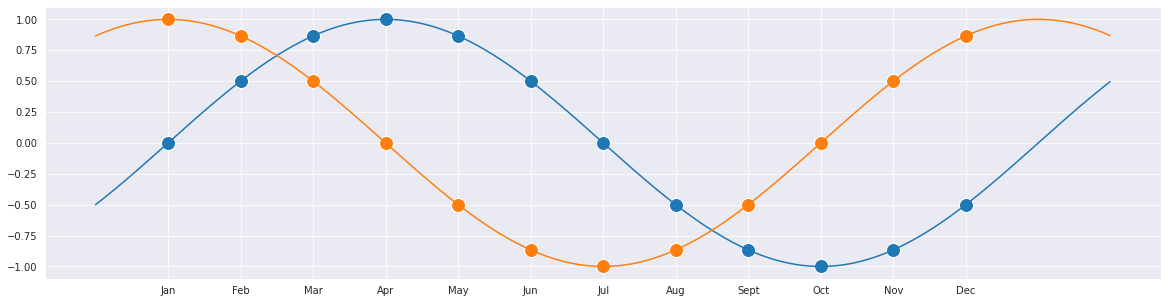

In [5]:
months = range(0, 12)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
# sin月份特征
months_sin = map(lambda x: math.sin(2 * math.pi * x / len(months)), months)
# cos月份特征
months_cos = map(lambda x: math.cos(2 * math.pi * x / len(months)), months)

# 绘制每个月的月份特征组合
plt.figure(figsize=(20, 5))
x_axis = np.arange(-1, 13, 1e-2)
sns.lineplot(x=x_axis, y=np.sin(2 * math.pi * x_axis / len(months)))
sns.lineplot(x=x_axis, y=np.cos(2 * math.pi * x_axis / len(months)))
sns.scatterplot(x=months, y=months_sin, s=200)
sns.scatterplot(x=months, y=months_cos, s=200)
plt.xticks(ticks=months, labels=month_labels)
plt.show()

构造SODA数据的sin月份特征。

In [6]:
# 构造一个维度为100*36*24*72的矩阵，矩阵中的每个值为所在月份的sin函数值
soda_month_sin = np.zeros((100, 36, 24, 72))
for y in range(100):
    for m in range(36):
        for lat in range(24):
            for lon in range(72):
                soda_month_sin[y, m, lat, lon] = math.sin(2 * math.pi * (m % 12) / 12)
                
soda_month_sin.shape

(100, 36, 24, 72)

构造SODA数据的cos月份特征。

In [7]:
# 构造一个维度为100*36*24*72的矩阵，矩阵中的每个值为所在月份的cos函数值
soda_month_cos = np.zeros((100, 36, 24, 72))
for y in range(100):
    for m in range(36):
        for lat in range(24):
            for lon in range(72):
                soda_month_cos[y, m, lat, lon] = math.cos(2 * math.pi * (m % 12) / 12)
                
soda_month_cos.shape

(100, 36, 24, 72)

构造CMIP数据的sin月份特征。

In [8]:
# 构造一个维度为4645*36*24*72的矩阵，矩阵中的每个值为所在月份的sin函数值
cmip_month_sin = np.zeros((4645, 36, 24, 72))
for y in range(4645):
    for m in range(36):
        for lat in range(24):
            for lon in range(72):
                cmip_month_sin[y, m, lat, lon] = math.sin(2 * math.pi * (m % 12) / 12)
                
cmip_month_sin.shape

(4645, 36, 24, 72)

构造CMIP数据的cos月份特征。

In [9]:
# 构造一个维度为4645*36*24*72的矩阵，矩阵中的每个值为所在月份的cos函数值
cmip_month_cos = np.zeros((4645, 36, 24, 72))
for y in range(4645):
    for m in range(36):
        for lat in range(24):
            for lon in range(72):
                cmip_month_cos[y, m, lat, lon] = math.cos(2 * math.pi * (m % 12) / 12)
                
cmip_month_cos.shape

(4645, 36, 24, 72)

#### 数据扁平化

在Task2中我们发现，赛题中给出的数据量非常少，如何增加数据量呢？对于时序数据，一种常用的做法就是滑窗。

由于每条数据在时间上有重叠，我们取数据的前12个月拼接起来，就得到了长度为（数据条数×12个月）的序列数据，如图1所示：
<img src="./fig/Task3-样本拼接示意图.png" width="70%">

然后我们以每个月为起始月，接下来的12个月作为模型输入X，后24个月的Nino3.4指数作为预测目标Y构建训练样本，如图2所示：
<img src="./fig/Task3-滑窗构造训练样本.png" width="70%">

需要注意的是，CMIP数据提供了不同的拟合模式，只有在同种模式下各个年份的数据在时间上是连续的，因此同种模式的数据才能在时间上拼接起来，除去最后11个月不能构成训练样本外，滑窗最终能获得的训练样本数量可以按以下方式计算得到：

- SODA：1种模式×（100年×12-11）=1189条样本
- CMIP6：15种模式×（151年×12-11）=27015条样本
- CMIP5：17种模式×（140年×12-11）=28373条样本

在下面的代码中，我们只将各个模式的数据拼接起来而没有采用滑窗，这是因为考虑到采用滑窗得到的训练样本维度是（数据条数×12×24×72），需要占用大量的内存资源。我们在之后构建数据集时，随机抽取了部分样本，大家在实际问题中，如果资源足够的话，可以采用滑窗构建的全部的数据，不过需要注意数据量大的情况下可以考虑构建更深的模型来挖掘更多信息。

In [10]:
def make_flatted(train_ds, label_ds, month_sin, month_cos, info, start_idx=0):
    keys = ['sst', 't300', 'ua', 'va']
    label_key = 'nino'
    # 年数
    years = info[1]
    # 模式数
    models = info[2]
    
    train_list = []
    label_list = []
    
    # 将同种模式下的数据拼接起来
    for model_i in range(models):
        blocks = []
        
        # 对每个特征，取每条数据的前12个月进行拼接
        for key in keys:
            block = train_ds[key][start_idx + model_i * years: start_idx + (model_i + 1) * years, :12].reshape(-1, 24, 72, 1).data
            blocks.append(block)
        # 增加sin月份特征
        block_sin = month_sin[start_idx + model_i * years: start_idx + (model_i + 1) * years, :12].reshape(-1, 24, 72, 1)
        blocks.append(block_sin)
        # 增加cos月份特征
        block_cos = month_cos[start_idx + model_i * years: start_idx + (model_i + 1) * years, :12].reshape(-1, 24, 72, 1)
        blocks.append(block_cos)
        
        # 将所有特征在最后一个维度上拼接起来
        train_flatted = np.concatenate(blocks, axis=-1)
        
        # 取12-23月的标签进行拼接，注意加上最后一年的最后12个月的标签（与最后一年12-23月的标签共同构成最后一年前12个月的预测目标）
        label_flatted = np.concatenate([
            label_ds[label_key][start_idx + model_i * years: start_idx + (model_i + 1) * years, 12: 24].reshape(-1).data,
            label_ds[label_key][start_idx + (model_i + 1) * years - 1, 24: 36].reshape(-1).data
        ], axis=0)
        
        train_list.append(train_flatted)
        label_list.append(label_flatted)
        
    return train_list, label_list

In [11]:
soda_info = ('soda', 100, 1)
cmip6_info = ('cmip6', 151, 15)
cmip5_info = ('cmip5', 140, 17)

soda_trains, soda_labels = make_flatted(soda_train, soda_label, soda_month_sin, soda_month_cos, soda_info)
cmip6_trains, cmip6_labels = make_flatted(cmip_train, cmip_label, cmip_month_sin, cmip_month_cos, cmip6_info)
cmip5_trains, cmip5_labels = make_flatted(cmip_train, cmip_label, cmip_month_sin, cmip_month_cos, cmip5_info, cmip6_info[1]*cmip6_info[2])

# 得到扁平化后的数据维度为（模式数×序列长度×纬度×经度×特征数），其中序列长度=年数×12
np.shape(soda_trains), np.shape(cmip6_trains), np.shape(cmip5_trains)

((1, 1200, 24, 72, 6), (15, 1812, 24, 72, 6), (17, 1680, 24, 72, 6))

In [12]:
del soda_month_sin, soda_month_cos
del cmip_month_sin, cmip_month_cos
del soda_train, soda_label
del cmip_train, cmip_label

#### 空值填充

在Task2中我们发现，除SST外，其它特征中都存在空值，这些空值基本都在陆地上，因此我们直接将空值填充为0。

In [13]:
# 填充SODA数据中的空值
soda_trains = np.array(soda_trains)
soda_trains_nan = np.isnan(soda_trains)
soda_trains[soda_trains_nan] = 0
print('Number of null in soda_trains after fillna:', np.sum(np.isnan(soda_trains)))

Number of null in soda_trains after fillna: 0


In [14]:
# 填充CMIP6数据中的空值
cmip6_trains = np.array(cmip6_trains)
cmip6_trains_nan = np.isnan(cmip6_trains)
cmip6_trains[cmip6_trains_nan] = 0
print('Number of null in cmip6_trains after fillna:', np.sum(np.isnan(cmip6_trains)))

Number of null in cmip6_trains after fillna: 0


In [15]:
# 填充CMIP5数据中的空值
cmip5_trains = np.array(cmip5_trains)
cmip5_trains_nan = np.isnan(cmip5_trains)
cmip5_trains[cmip5_trains_nan] = 0
print('Number of null in cmip6_trains after fillna:', np.sum(np.isnan(cmip5_trains)))

Number of null in cmip6_trains after fillna: 0


#### 构造数据集

在划分训练/验证集时，一个需要考虑的问题是训练集、验证集、测试集三者的分布是否是一致的。在本赛题中我们拿到的是两份数据，其中CMIP数据是CMIP5/6模式模拟的历史数据，SODA数据是由SODA模式重建的的历史观测同化数据，线上测试集则是来自国际多个海洋资料的同化数据，由此看来，SODA数据和线上测试集的分布是较为一致的，CMIP数据的分布则与测试集不同。在三者不一致的情况下，我们通常会尽可能使验证集与测试集的分布一致，这样当模型在验证集上有较好的表现时，在测试集上也会有较好的表现。

因此，我们从CMIP数据的每个模式中各抽取100条数据作为训练集（这里抽取的样本数只是作为一个示例，实际模型训练的时候使用多少样本需要综合考虑可用的资源条件和构建的模型深度），从SODA模式中抽取100条数据作为验证集。有的同学可能会疑惑，既然这里只用了100条SODA数据，那么为什么还要对SODA数据扁平化后再抽样而不直接用原始数据呢，因为直接取原始数据的前12个月作为输入，后24个月作为标签所得到的验证集每一条都是从0月开始的，而线上的测试集起始月份是随机抽取的，因此这里仍然要尽可能保证验证集与测试集的数据分布一致，使构建的验证集的起始月份也是随机的。

我们这里没有构造测试集，因为线上的测试集已经公开了，可以直接使用，在比赛时，线上的测试集是保密的，需要构造线下的测试集来评估模型效果，同时需要注意线下的评估结果和线上的提交结果是否差距不大或者变化趋势是一致的，如果不是就需要调整线下的测试集，保证它和线上测试集的分布尽可能一致，能够较为准确地指示模型的调整方向。

In [16]:
# 构造训练集

X_train = []
y_train = []
# 从CMIP5的17种模式中各抽取100条数据
for model_i in range(17):
    samples = np.random.choice(cmip5_trains.shape[1]-12, size=100)
    for ind in samples:
        X_train.append(cmip5_trains[model_i, ind: ind+12])
        y_train.append(cmip5_labels[model_i][ind: ind+24])
# 从CMIP6的15种模式种各抽取100条数据
for model_i in range(15):
    samples = np.random.choice(cmip6_trains.shape[1]-12, size=100)
    for ind in samples:
        X_train.append(cmip6_trains[model_i, ind: ind+12])
        y_train.append(cmip6_labels[model_i][ind: ind+24])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [17]:
# 构造测试集

X_valid = []
y_valid = []
samples = np.random.choice(soda_trains.shape[1]-12, size=100)
for ind in samples:
    X_valid.append(soda_trains[0, ind: ind+12])
    y_valid.append(soda_labels[0][ind: ind+24])
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [18]:
# 查看数据集维度
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3200, 12, 24, 72, 6), (3200, 24), (100, 12, 24, 72, 6), (100, 24))

In [19]:
del cmip5_trains, cmip5_labels
del cmip6_trains, cmip6_labels
del soda_trains, soda_labels

In [20]:
# 保存数据集
np.save('X_train_sample.npy', X_train)
np.save('y_train_sample.npy', y_train)
np.save('X_valid_sample.npy', X_valid)
np.save('y_valid_sample.npy', y_valid)

### 模型构建

在模型构建部分的通用流程是：构造评估函数 -> 构建并训练模型 -> 模型评估，后两步是循环的，可以根据评估结果重新调整并训练模型，再重新进行评估。

#### 构造评估函数

模型的评估函数通常就是官方给出的评估指标，不过在比赛中经常会出现线下的评估结果和提交后的线上评估结果不一致的情况，这通常是线下测试集和线上测试集分布不一致造成的。

In [21]:
# 读取数据集
X_train = np.load('../input/ai-earth-task03-samples/X_train_sample.npy')
y_train = np.load('../input/ai-earth-task03-samples/y_train_sample.npy')
X_valid = np.load('../input/ai-earth-task03-samples/X_valid_sample.npy')
y_valid = np.load('../input/ai-earth-task03-samples/y_valid_sample.npy')

In [22]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3200, 12, 24, 72, 6), (3200, 24), (100, 12, 24, 72, 6), (100, 24))

In [23]:
# 构造数据管道
class AIEarthDataset(Dataset):
    def __init__(self, data, label):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.label = torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [24]:
batch_size = 32

trainset = AIEarthDataset(X_train, y_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

validset = AIEarthDataset(X_valid, y_valid)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)

#### 模型构造与训练

这部分是赛题的重点，该TOP方案采用的是CNN+LSTM的串行结构，其中CNN用来提取空间信息，LSTM用来提取时间信息，模型结构如下图所示。

<img src="./fig/Task3-CNN+LSTM模型.png" width="15%">

- CNN部分

CNN常用于处理图像信息，它在处理空间信息上也有很好的表现。CNN的输入尺寸是（N,C,H,W），其中N是批量梯度下降中一个批次的样本数量，H和W分别是输入图像的高和宽，C是输入图像的通道数，对于本题中的空间数据，H和W就对应数据的纬度和经度，C对应特征数。我们的训练样本中还多了一个时间维度，因此需要用将输入数据的格式(N,T,H,W,C)转换为(N×T,C,H,W)。

BatchNormalization（后面简称BN）是批标准化层，通常放在卷积层后用于标准化数据的分布，能够减少各层不同数据分布之间的相互影响和依赖，具有加快模型训练速度、避免梯度爆炸、在一定程度上能增强模型泛化能力等优点，是神经网络问题中常用的“大杀器”。不过目前关于BN层和ReLU激活函数的放置顺序孰先孰后的问题众说纷纭，具体还是看模型的效果。关于这个问题的讨论可以参考https://www.zhihu.com/question/283715823

总体来看CNN这一部分采用的是比较通用的结构，第一层采用比较大的卷积核（7×7），后面接多层的小卷积核（3×3），并用BN提升模型效果，用池化层减少模型参数、扩大感受野，池化层常用的有MaxPooling和AveragePooling，通常MaxPooling效果更好，不过具体看模型效果。模型的主要难点就在于调参，目前模型调参没有标准的答案，更多地是参考前人的经验以及不断地尝试。

- LSTM部分

CNN部分经过Flatten层将除时间维度以外的维度压平（即除时间步长12外的其它维度大小相乘，例如CNN部分最后的池化层输出维度是（N,T,C,H,W），则压平后的维度是（N,T,C×H×W）），输入LSTM层。LSTM层接受的输入维度为（Time_steps，Input_size），其中Time_steps就是时间步长12，Input_size是压平后的维度大小。Pytorch中LSTM的主要参数是input_size、hidden_size（隐层节点数）、batch_first（一个批次的样本数量N是否在第1维度），batch_first为True时输入和输出的数据格式为(N,T,input_size/hidden_size)，为数据格式为(T,N,input_size/hidden_size)，需要注意的一点是LSTM的输出形式是tensor格式的output和tuple格式的(h_n,c_n)，其中output是所有时间步的输出(N,T,hidden_size)，h_n是隐层的输出（即最后一个时间步的输出，格式为(1,N,hidden_size)），c_n是记忆细胞cell的输出。因为我们通过多层LSTM要获得的并非一个时间序列，而是要抽取出一个关于输入序列的特征表达，因此最后我们使用最后一个LSTM层的隐层输出h_n作为全连接层的输入。LSTM的使用方法可以参考https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM

由于LSTM有四个门，因此LSTM的参数量是4倍的Input_size×hidden_size，参数量过多就容易过拟合，同时由于数据量也较少，因此该方案中只堆叠了两个LSTM层。

In [25]:
# 构造模型
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 32, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(32)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.lstm1 = nn.LSTM(3456, 2048, batch_first=True)
        self.lstm2 = nn.LSTM(2048, 1024, batch_first=True)
        self.fc = nn.Linear(1024, 24)
        
    def forward(self, x):
        # 转换输入形状
        N, T, H, W, C = x.shape
        x = x.permute(0, 1, 4, 2, 3).contiguous()
        x = x.view(N*T, C, H, W)
        
        # CNN部分
        x = self.conv1(x)
        x = F.relu(self.bn(x))
        x = self.conv2(x)
        x = F.relu(self.bn(x))
        x = self.avgpool(x)
        x = self.flatten(x)

        # 注意Flatten层后输出为(N×T,C_new)，需要转换成(N,T,C_new)
        _, C_new = x.shape
        x = x.view(N, T, C_new)
        
        # LSTM部分
        x, h = self.lstm1(x)
        x, h = self.lstm2(x)
        # 注意这里只使用隐层的输出
        x, _ = h
        
        x = self.fc(x.squeeze())
        
        return x

In [26]:
def rmse(y_true, y_preds):
    return np.sqrt(mean_squared_error(y_pred = y_preds, y_true = y_true))

# 评估函数
def score(y_true, y_preds):
    # 相关性技巧评分
    accskill_score = 0
    # RMSE
    rmse_scores = 0
    a = [1.5] * 4 + [2] * 7 + [3] * 7 + [4] * 6
    y_true_mean = np.mean(y_true, axis=0)
    y_pred_mean = np.mean(y_preds, axis=0)
    for i in range(24):
        fenzi = np.sum((y_true[:, i] - y_true_mean[i]) * (y_preds[:, i] - y_pred_mean[i]))
        fenmu = np.sqrt(np.sum((y_true[:, i] - y_true_mean[i])**2) * np.sum((y_preds[:, i] - y_pred_mean[i])**2))
        cor_i = fenzi / fenmu
        accskill_score += a[i] * np.log(i+1) * cor_i
        rmse_score = rmse(y_true[:, i], y_preds[:, i])
        rmse_scores += rmse_score
    return 2/3.0 * accskill_score - rmse_scores

In [27]:
model = Model()
print(model)

Model(
  (conv1): Conv2d(6, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lstm1): LSTM(3456, 2048, batch_first=True)
  (lstm2): LSTM(2048, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=24, bias=True)
)


考虑到本次任务的评价指标score=2/3×accskill-RMSE，其中RMSE是24个月的rmse的累计值，我们这里可以自定义评价指标中的RMSE作为损失函数。

In [28]:
# 采用RMSE作为损失函数
def RMSELoss(y_pred,y_true):
    loss = torch.sqrt(torch.mean((y_pred-y_true)**2, dim=0)).sum()
    return loss

In [29]:
model_weights = './task03_model_weights.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Model().to(device)
criterion = RMSELoss
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)  # weight_decay是L2正则化参数
epochs = 10
train_losses, valid_losses = [], []
scores = []
best_score = float('-inf')
preds = np.zeros((len(y_valid),24))

for epoch in range(epochs):
    print('Epoch: {}/{}'.format(epoch+1, epochs))
    
    # 模型训练
    model.train()
    losses = 0
    for data, labels in tqdm(trainloader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, labels)
        losses += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()
    train_loss = losses / len(trainloader)
    train_losses.append(train_loss)
    print('Training Loss: {:.3f}'.format(train_loss))
    
    # 模型验证
    model.eval()
    losses = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(validloader)):
            data, labels = data
            data = data.to(device)
            labels = labels.to(device)
            pred = model(data)
            loss = criterion(pred, labels)
            losses += loss.cpu().detach().numpy()
            preds[i*batch_size:(i+1)*batch_size] = pred.detach().cpu().numpy()
    valid_loss = losses / len(validloader)
    valid_losses.append(valid_loss)
    print('Validation Loss: {:.3f}'.format(valid_loss))
    s = score(y_valid, preds)
    scores.append(s)
    print('Score: {:.3f}'.format(s))
    
    # 保存最佳模型权重
    if s > best_score:
        best_score = s
        checkpoint = {'best_score': s,
                      'state_dict': model.state_dict()}
        torch.save(checkpoint, model_weights)

Epoch: 1/10


100%|██████████| 100/100 [00:04<00:00, 20.67it/s]


Training Loss: 18.423


4it [00:00, 52.20it/s]


Validation Loss: 17.787
Score: -10.458
Epoch: 2/10


100%|██████████| 100/100 [00:04<00:00, 21.10it/s]


Training Loss: 16.106


4it [00:00, 52.00it/s]


Validation Loss: 16.873
Score: -15.903
Epoch: 3/10


100%|██████████| 100/100 [00:04<00:00, 21.29it/s]


Training Loss: 15.436


4it [00:00, 52.55it/s]


Validation Loss: 16.488
Score: -28.155
Epoch: 4/10


100%|██████████| 100/100 [00:04<00:00, 21.25it/s]


Training Loss: 15.036


4it [00:00, 53.23it/s]


Validation Loss: 16.916
Score: -22.716
Epoch: 5/10


100%|██████████| 100/100 [00:04<00:00, 21.27it/s]


Training Loss: 14.674


4it [00:00, 52.23it/s]


Validation Loss: 16.502
Score: -23.859
Epoch: 6/10


100%|██████████| 100/100 [00:04<00:00, 21.22it/s]


Training Loss: 14.167


4it [00:00, 52.26it/s]


Validation Loss: 17.340
Score: -19.200
Epoch: 7/10


100%|██████████| 100/100 [00:04<00:00, 21.26it/s]


Training Loss: 13.599


4it [00:00, 52.89it/s]


Validation Loss: 18.158
Score: -17.133
Epoch: 8/10


100%|██████████| 100/100 [00:04<00:00, 21.00it/s]


Training Loss: 12.915


4it [00:00, 40.89it/s]


Validation Loss: 21.207
Score: -26.217
Epoch: 9/10


100%|██████████| 100/100 [00:04<00:00, 20.92it/s]


Training Loss: 12.190


4it [00:00, 51.79it/s]


Validation Loss: 17.459
Score: -37.787
Epoch: 10/10


100%|██████████| 100/100 [00:04<00:00, 21.26it/s]


Training Loss: 11.559


4it [00:00, 52.77it/s]

Validation Loss: 17.482
Score: -14.426


In [30]:
# 绘制训练/验证曲线
def training_vis(train_losses, valid_losses):
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(train_losses, label='train_loss')
    ax1.plot(valid_losses,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    plt.tight_layout()

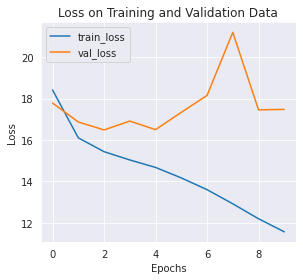

In [31]:
training_vis(train_losses, valid_losses)

我们通常会绘制训练/验证曲线来观察模型的拟合情况，上图中我们分别绘制了训练过程中训练集和验证集损失函数变化曲线。可以看到，训练集的损失函数下降很快，但是验证集的损失函数是震荡的，没有明显的下降，这说明模型的学习效果较差，并存在过拟合问题，需要调整相关的参数。

#### 模型评估

最后，我们在测试集上评估模型的训练结果。

In [32]:
# 加载最佳模型权重
checkpoint = torch.load('../input/ai-earth-model-weights/task03_model_weights.pth')
model = Model()
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [33]:
# 测试集路径
test_path = '../input/ai-earth-tests/'
# 测试集标签路径
test_label_path = '../input/ai-earth-tests-labels/'

In [34]:
import os

# 读取测试数据和测试数据的标签，并记录每个测试样本的起始月份用于之后构造月份特征
files = os.listdir(test_path)
X_test = []
y_test = []
first_months = []  # 样本起始月份
for file in files:
    X_test.append(np.load(test_path + file))
    y_test.append(np.load(test_label_path + file))
    first_months.append(int(file.split('_')[2]))

In [35]:
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test.shape, y_test.shape

((103, 12, 24, 72, 4), (103, 24))

In [36]:
# 构造一个维度为103*12*24*72的矩阵，矩阵中的每个值为所在月份的sin函数值
test_month_sin = np.zeros((103, 12, 24, 72, 1))
for y in range(103):
    for m in range(12):
        for lat in range(24):
            for lon in range(72):
                test_month_sin[y, m, lat, lon] = math.sin(2 * math.pi * ((m + first_months[y]-1) % 12) / 12)
                
test_month_sin.shape

(103, 12, 24, 72, 1)

In [37]:
# 构造一个维度为103*12*24*72的矩阵，矩阵中的每个值为所在月份的cos函数值
test_month_cos = np.zeros((103, 12, 24, 72, 1))
for y in range(103):
    for m in range(12):
        for lat in range(24):
            for lon in range(72):
                test_month_cos[y, m, lat, lon] = math.cos(2 * math.pi * ((m + first_months[y]-1) % 12) / 12)
                
test_month_cos.shape

(103, 12, 24, 72, 1)

In [38]:
# 构造测试集
X_test = np.concatenate([X_test, test_month_sin, test_month_cos], axis=-1)
X_test.shape

(103, 12, 24, 72, 6)

In [39]:
testset = AIEarthDataset(X_test, y_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [40]:
# 在测试集上评估模型效果
model.eval()
model.to(device)
preds = np.zeros((len(y_test),24))
for i, data in tqdm(enumerate(testloader)):
    data, labels = data
    data = data.to(device)
    labels = labels.to(device)
    pred = model(data)
    preds[i*batch_size:(i+1)*batch_size] = pred.detach().cpu().numpy()
s = score(y_test, preds)
print('Score: {:.3f}'.format(s))

4it [00:00, 65.03it/s]

Score: 14.946


## 总结

- 该方案在数据处理部分增加了一组月份特征，个人认为在使用了时序模型的情况下增加的这组特征收益不高，并且由于维度增加会使得训练数据占用内存大大增加，在本赛题中对模型的效果提升不明显。不过在其他场景中这种特征构造方法仍然是值得借鉴的。
- 该方案构造模型的思路非常适合初学者学习，灵活地将不同模型串行结合能够结合模型各自的优势，这种模型构造方法需要注意的是一个模型的输出维度与另一个模型接受的输入维度要相互匹配。

## 参考文献
1. “学习AI的打工人”经验分享：https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12586969.1002.18.561d5330HKwYOW&postId=196536